In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
features_file_path = '/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/UCI HAR Dataset/features.txt'

In [ ]:
features_df = pd.read_csv(features_file_path, delim_whitespace=True, header=None, names=['id', 'name'])
feature_names_series = features_df['name']

# 2. 중복된 이름을 찾아 고유하게 만듭니다 (예: 'featureName_1', 'featureName_2')
# 그룹별 누적 카운트를 계산합니다.
counts = feature_names_series.groupby(feature_names_series).cumcount()

# 카운트가 0보다 큰 (즉, 중복된) 이름 뒤에 _count를 붙입니다.
unique_feature_names = [
    f"{name}_{count}" if count > 0 else name
    for name, count in zip(feature_names_series, counts)
]

/tmp/ipython-input-3293608632.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features_df = pd.read_csv(features_file_path, delim_whitespace=True, header=None, names=['id', 'name'])


In [ ]:
# 액티비티 레이블 로드
activity_labels_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/UCI HAR Dataset/activity_labels.txt', delim_whitespace=True, header=None)
activity_labels = dict(zip(activity_labels_df[0], activity_labels_df[1]))

/tmp/ipython-input-1615085894.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  activity_labels_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/UCI HAR Dataset/activity_labels.txt', delim_whitespace=True, header=None)


In [ ]:
# 3. 학습 데이터 로드
# (수정 1: sep='\s+' -> delim_whitespace=True 로 변경하여 SyntaxWarning 해결)
# (수정 2: names=feature_names -> names=unique_feature_names 로 변경하여 ValueError 해결)
X_train_df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/UCI HAR Dataset/train/X_train.txt',
    delim_whitespace=True,
    header=None,
    names=unique_feature_names
)
y_train_df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/UCI HAR Dataset/train/y_train.txt',
    header=None,
    names=['ActivityID']
)

/tmp/ipython-input-3466081903.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train_df = pd.read_csv(


In [ ]:
# 테스트 데이터 로드
X_test_df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/UCI HAR Dataset/test/X_test.txt',
    delim_whitespace=True,
    header=None,
    names=unique_feature_names
)
y_test_df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/UCI HAR Dataset/test/y_test.txt',
    header=None,
    names=['ActivityID']
)

/tmp/ipython-input-3770843053.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test_df = pd.read_csv(


In [ ]:
# 학습/테스트 데이터 병합 (원본 로직을 따르기 위해)
X_df = pd.concat([X_train_df, X_test_df], axis=0)
y_df = pd.concat([y_train_df, y_test_df], axis=0)

In [ ]:
# ActivityID를 실제 레이블 이름으로 매핑
data = X_df.copy()
data['Activity'] = y_df['ActivityID'].map(activity_labels)

In [ ]:
# 2. 데이터 필터링 및 전처리
NORMAL_CLASS = 'LAYING'
ANOMALY_CLASS = 'WALKING'
LABELS = ["Normal (LAYING)", "Anomaly (WALKING)"]
RANDOM_SEED = 42

In [ ]:
# 'LAYING'과 'WALKING' 데이터만 필터링
data_filtered = data[(data['Activity'] == NORMAL_CLASS) | (data['Activity'] == ANOMALY_CLASS)].copy()

In [ ]:
# 이진 클래스 생성 (Normal=0, Anomaly=1)
data_filtered['Class'] = data_filtered['Activity'].apply(lambda x: 0 if x == NORMAL_CLASS else 1)
data_filtered = data_filtered.drop('Activity', axis=1)

In [ ]:
# 피처와 레이블 분리 (X, y)
X = data_filtered.drop('Class', axis=1)
y = data_filtered['Class']

In [ ]:
# 3. 학습/테스트 분리 및 스케일링 (AE_credit.ipynb 로직 적용)
# 3-1. 전체 데이터를 학습/테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)

In [ ]:
# 3-2. 학습 데이터(X_train)에서 '정상' (Class=0, 'LAYING') 데이터만 추출
X_train_normal = X_train[y_train == 0]

In [ ]:
# 3-3. StandardScaler를 '정상' 데이터로만 fit
scaler = StandardScaler()
scaler.fit(X_train_normal)

StandardScaler()

In [ ]:
# 3-4. '정상' 학습 데이터와 '전체' 테스트 데이터를 스케일링
X_train_normal_scaled = scaler.transform(X_train_normal)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# LSTM 입력을 위한 3D 변환
# (samples, features) -> (samples, timesteps, features_per_step)
# 여기서는 561개를 561 timesteps, 1 feature_per_step으로 취급
X_train_3d = X_train_normal_scaled.reshape(
    (X_train_normal_scaled.shape[0], X_train_normal_scaled.shape[1], 1)
)
X_test_3d = X_test_scaled.reshape(
    (X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
)
print(f"X_train_3d shape: {X_train_3d.shape}") # (샘플 수, 561, 1)

X_train_3d shape: (1361, 561, 1)


In [ ]:
# 2. LSTM 오토인코더 정의
# (Encoder-Decoder 구조)
input_dim_cnn = (X_train_3d.shape[1], X_train_3d.shape[2]) # (561, 1)

input_layer_cnn = Input(shape=input_dim_cnn)

# Encoder
x = Conv1D(filters=32, kernel_size=7, activation='relu', padding='same')(input_layer_cnn)
x = MaxPooling1D(pool_size=2, padding='same')(x) # 561 -> 281
x = Conv1D(filters=16, kernel_size=7, activation='relu', padding='same')(x)
encoded_cnn = MaxPooling1D(pool_size=2, padding='same')(x) # 281 -> 141 (Bottleneck)

# Decoder
x = Conv1D(filters=16, kernel_size=7, activation='relu', padding='same')(encoded_cnn)
x = UpSampling1D(size=2)(x) # 141 -> 282 (패딩 문제로 1 차이 날 수 있음, 'same' 패딩이 도움됨)
x = Conv1D(filters=32, kernel_size=7, activation='relu', padding='same')(x)
x = UpSampling1D(size=2)(x) # 282 -> 564
decoded_cnn_raw = Conv1D(filters=1, kernel_size=7, activation=None, padding='same')(x)

# 입력 shape(561, 1)과 정확히 맞추기 위해 Cropping 또는 Dense 레이어 사용
# 여기서는 UpSampling/Padding으로 인해 크기가 다를 수 있으므로 Dense로 마무리
from tensorflow.keras.layers import Flatten, Reshape, Cropping1D
# 564 -> 561로 맞추기 (예시)
if decoded_cnn_raw.shape[1] > input_dim_cnn[0]:
    decoded_cnn = Cropping1D(cropping=(0, decoded_cnn_raw.shape[1] - input_dim_cnn[0]))(decoded_cnn_raw)
else:
    # (패딩 등으로 크기가 같거나 작은 경우 - 여기서는 UpSampling(564)으로 더 큼)
    decoded_cnn = decoded_cnn_raw # 실제로는 패딩 레이어가 필요할 수 있음

cnn_autoencoder = Model(inputs=input_layer_cnn, outputs=decoded_cnn)
cnn_autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
cnn_autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 561, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 561, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 281, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 281, 16)        │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 141, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 141, 16)        │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 282, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 282, 32)        │         3,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 564, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 564, 1)         │           225 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_1 (Cropping1D)       │ (None, 561, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 5. 모델 학습 (3D 데이터로 학습)
cnn_history = cnn_autoencoder.fit(
    X_train_3d, X_train_3d,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.7964 - val_loss: 0.4384
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4686 - val_loss: 0.3945
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4224 - val_loss: 0.3705
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4003 - val_loss: 0.3476
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3553 - val_loss: 0.3311
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3208 - val_loss: 0.3048
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3072 - val_loss: 0.2711
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2639 - val_loss: 0.2321
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2541 - val_loss: 0.2051
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2454 - val_loss: 0.1871
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1975 - val_loss: 0.1731
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1751 - val_l

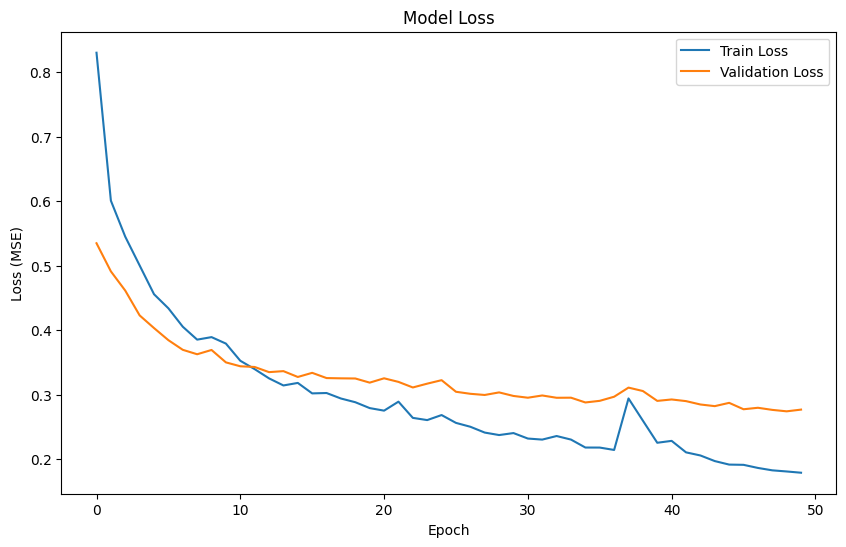

In [ ]:
# 학습 손실 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# 6. 평가 및 임계값 설정
# 6-1. 학습에 사용된 '정상' 데이터의 재구성 오류 계산 (임계값 설정을 위해)
predictions_train = cnn_autoencoder.predict(X_train_3d)
mse_train = np.mean(np.power(X_train_3d - predictions_train, 2), axis=(1, 2))

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
# 6-2. 임계값 설정: 정상 데이터의 (평균 + 3*표준편차)
threshold = np.mean(mse_train) + 3 * np.std(mse_train)
print(f"Calculated Threshold: {threshold}")

Calculated Threshold: 0.27065349837924746


In [ ]:
# 6-3. '테스트' 데이터의 재구성 오류 계산
predictions_test = cnn_autoencoder.predict(X_test_3d)
mse_test = np.mean(np.power(X_test_3d - predictions_test, 2), axis=(1, 2))

error_df = pd.DataFrame({'reconstruction_error': mse_test,
                         'true_class': y_test})
error_df.describe()

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,reconstruction_error,true_class
count,1100.000000,1100.000000
mean,14.629376,0.470000
std,28.151708,0.499326
min,0.008723,0.000000
25%,0.022415,0.000000
50%,0.122382,0.000000
75%,17.848744,1.000000
max,289.633197,1.000000


In [ ]:
error_df.head()

,reconstruction_error,true_class
78,0.014208,0
982,0.030104,0
1236,0.039345,0
3750,56.628115,1
2653,0.189421,0


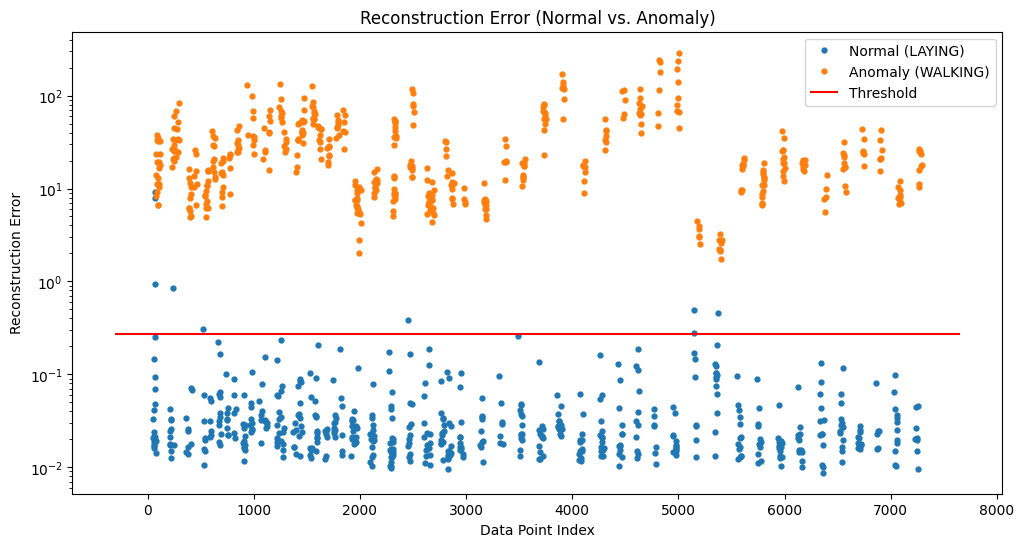

In [ ]:
# 6-4. 클래스별 재구성 오류 시각화
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(12, 6))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= LABELS[name])

ax.set_yscale('log')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction Error (Normal vs. Anomaly)")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.show()

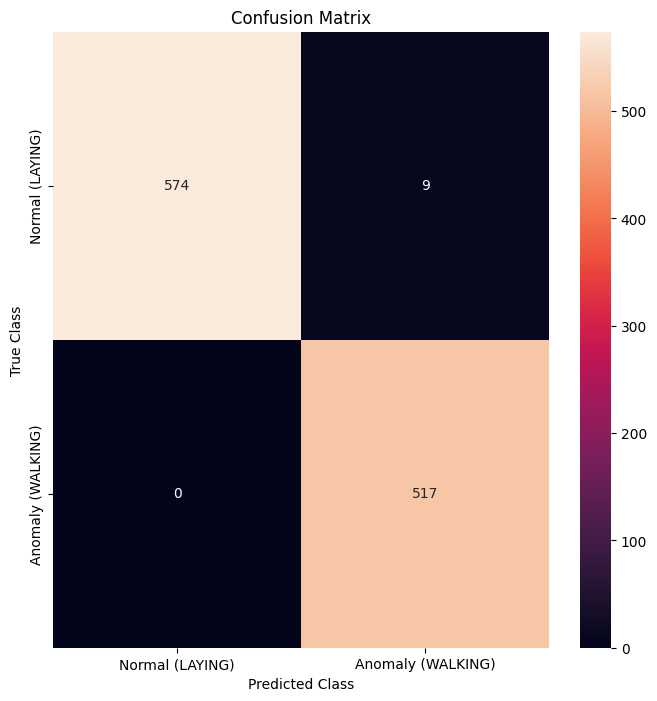

In [ ]:
# 7. 결과 분석 (오차 행렬 및 분류 리포트)
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
print(classification_report(error_df.true_class, y_pred, target_names=LABELS))

                   precision    recall  f1-score   support

  Normal (LAYING)       1.00      0.98      0.99       583
Anomaly (WALKING)       0.98      1.00      0.99       517

         accuracy                           0.99      1100
        macro avg       0.99      0.99      0.99      1100
     weighted avg       0.99      0.99      0.99      1100

